In [4]:
!pip install m3_learning --no-deps
!pip install -r requirements.txt

In [5]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
import os
from torch.utils.data import Dataset, DataLoader
import time
from torch.optim.lr_scheduler import StepLR

from m3_learning.nn.time_series_nn.nn_util import Train, transform_nn
from m3_learning.util.rand_util import rand_tensor
from m3_learning.viz.style import set_style
from m3_learning.nn.random import random_seed
set_style("printing")
random_seed(seed=42)

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


In [6]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

In [7]:
class Linear_func:
    def __init__(self, x, slope=[0,1], b=[0,1], size=(1,1),batch_size=1000, verbose=False):
        self.x = x

        self.slope = slope
        self.slope_mean = torch.tensor(slope[0] + slope[1]) / 2
        self.slope_sd = torch.sqrt(torch.pow(torch.tensor(slope[1]) - torch.tensor(slope[0]), 2) / 12)
        
        self.b = b
        self.b_mean = torch.tensor(b[0] + b[1]) / 2
        self.b_sd = torch.sqrt(torch.pow(torch.tensor(b[1]) - torch.tensor(b[0]), 2) / 12)
        
        self.size = size
        self.batch_size = batch_size
        self.verbose = verbose

    def compute(self, params, device='cuda:4'):
        if len(params.size()) == 2:
            params = torch.reshape(params, (params.shape[0], 3, -1))

        out = torch.zeros(
            (params.shape[0], self.x.shape[0],
             self.size[0], self.size[1])
        )

        params = params.to(device)

        for i in range(self.size[1]):

            if params.ndim == 4:
                _slope = params[:, 0, 0, i]
                _b = params[:, 0, 1, i]

            if params.ndim == 3:
                _slope = params[:, 0, i]
                _b = params[:, 1, i]

            x = (
                torch.cat(params.shape[0] * [self.x])
                .reshape(params.shape[0], -1)
                .to(device)
            )
            x = torch.transpose(x, 0, 1)  # .to(device)

            _out = _slope * x + _b

            out[:, :, 0, i] = torch.transpose(_out, 0, 1)

        return (torch.sum(out, dim=3), out)
    
    def sampler(self, device='cuda:4'):
        slope = rand_tensor(
            min=self.slope[0],
            max=self.slope[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )

        b = rand_tensor(
            min=self.b[0],
            max=self.b[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )

        _params = torch.torch.stack((slope, b))
        _params = torch.atleast_2d(_params)
        _params = torch.transpose(_params, 0, 1)
        _params = torch.transpose(_params, 1, 2)
        
        return (self.compute(_params, device=device), _params)

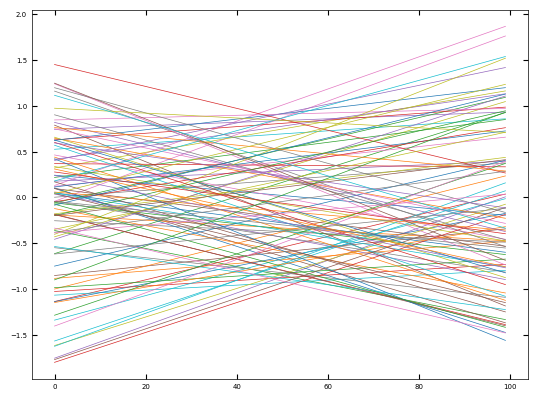

In [21]:
x_values = torch.linspace(-1, 1, 100)
constructor = Linear_func(x=x_values, slope=[-1,1], b=[-1,1], batch_size=100)
output = constructor.sampler()
spectra, params = output
spectra_full, spectras = spectra

dataloader = DataLoader(spectra_full, batch_size=10, shuffle=True, num_workers=0)

for i in range(100):
    plt.plot(spectra_full[i, :, 0], "-")

In [22]:
class Multiscale1DFitter(nn.Module):

    def __init__(self, function, x_data, input_channels, num_params, scaler=None,
                 post_processing=None, device="cuda:4", loops_scaler=None, **kwargs):
        self.input_channels = input_channels
        self.scaler = scaler
        self.function = function
        self.x_data = x_data
        self.post_processing = post_processing
        self.device = device
        self.num_params = num_params
        self.loops_scaler = loops_scaler

        super().__init__()

        # Input block of 1d convolution
        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.input_channels, out_channels=8, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(64)
        )

        # Fully connected block
        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.SELU(),
            nn.Linear(32, 20),
            nn.SELU(),
        )

        # 2nd block of 1d-conv layers
        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(16),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(8),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(4),
        )

        # Flatten layer
        self.flatten_layer = nn.Flatten()

        # Final embedding block
        self.hidden_embedding = nn.Sequential(
            nn.Linear(28, 16),
            nn.SELU(),
            nn.Linear(16, 8),
            nn.SELU(),
            nn.Linear(8, self.num_params),
        )

    def forward(self, x, n=-1):
        x = torch.swapaxes(x, 1, 2)  # Swap axes 1 and 2
        x = self.hidden_x1(x)
        xfc = torch.reshape(x, (n, 256))
        xfc = self.hidden_xfc(xfc)

        x = torch.reshape(x, (n, 2, 128))
        x = self.hidden_x2(x)
        cnn_flat = self.flatten_layer(x)

        encoded = torch.cat((cnn_flat, xfc), 1)
        embedding = self.hidden_embedding(encoded)
        unscaled_param = embedding

        if self.scaler is not None:
            unscaled_param = (embedding * torch.tensor(self.scaler.var_ ** 0.5).to(self.device)
                              + torch.tensor(self.scaler.mean_).to(self.device))
        else:
            unscaled_param = embedding

        fits = self.function(unscaled_param, self.x_data, device=self.device)
        out = fits

        if self.post_processing is not None:
            out = self.post_processing.compute(fits)
        else:
            out = fits

        if self.loops_scaler is not None:
            out_scaled = (out - torch.tensor(self.loops_scaler.mean).to(self.device)) / torch.tensor(self.loops_scaler.std).to(self.device)
        else:
            out_scaled = out

        return out_scaled, unscaled_param

In [11]:

def linear_function(params, x, device='cuda:4'):
    slope = params[:, 0].type(torch.float).unsqueeze(1)
    intercept = params[:, 1].type(torch.float).unsqueeze(1)
    y = slope * x + intercept
    return y

'''def linear_function(self, params, device='cuda:4'):
        if len(params.size()) == 2:
            params = torch.reshape(params, (params.shape[0], 3, -1))

        out = torch.zeros(
            (params.shape[0], self.x.shape[0],
             self.size[0], self.size[1])
        )

        params = params.to(device)

        for i in range(self.size[1]):

            if params.ndim == 4:
                _slope = params[:, 0, 0, i]
                _b = params[:, 0, 1, i]

            if params.ndim == 3:
                _slope = params[:, 0, i]
                _b = params[:, 1, i]

            x = (
                torch.cat(params.shape[0] * [self.x])
                .reshape(params.shape[0], -1)
                .to(device)
            )
            x = torch.transpose(x, 0, 1)  # .to(device)

            _out = _slope * x + _b

            out[:, :, 0, i] = torch.transpose(_out, 0, 1)

        return (torch.sum(out, dim=3), out)'''

"def linear_function(self, params, device='cuda:4'):\n        if len(params.size()) == 2:\n            params = torch.reshape(params, (params.shape[0], 3, -1))\n\n        out = torch.zeros(\n            (params.shape[0], self.x.shape[0],\n             self.size[0], self.size[1])\n        )\n\n        params = params.to(device)\n\n        for i in range(self.size[1]):\n\n            if params.ndim == 4:\n                _slope = params[:, 0, 0, i]\n                _b = params[:, 0, 1, i]\n\n            if params.ndim == 3:\n                _slope = params[:, 0, i]\n                _b = params[:, 1, i]\n\n            x = (\n                torch.cat(params.shape[0] * [self.x])\n                .reshape(params.shape[0], -1)\n                .to(device)\n            )\n            x = torch.transpose(x, 0, 1)  # .to(device)\n\n            _out = _slope * x + _b\n\n            out[:, :, 0, i] = torch.transpose(_out, 0, 1)\n\n        return (torch.sum(out, dim=3), out)"

In [23]:
model = Multiscale1DFitter(function=linear_function, x_data=x_values, input_channels=1, num_params=2, device=device)

In [25]:
random_seed(seed=42)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5)
# scheduler = StepLR(optimizer, step_size=100, gamma=0.1)

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


In [27]:
epochs = 100
for epoch in range(epochs):
    start_time = time.time()
    train_loss = 0.0
    total_num = 0
    model.train()

    for train_batch in dataloader:
        print(train_batch.shape)
        pred, _ = model(train_batch)
        optimizer.zero_grad()
        loss = loss_func(train_batch.squeeze(2), pred)
        optimizer.step()
        # scheduler.step()
        loss.backward()
        train_loss += loss.item() * pred.shape[0]
        total_num += pred.shape[0]
    train_loss /= total_num

    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch, epochs, train_loss))
    print("--- %s seconds ---" % (time.time() - start_time))

torch.Size([10, 100, 1])
torch.Size([10, 100, 1])
torch.Size([10, 100, 1])
torch.Size([10, 100, 1])
torch.Size([10, 100, 1])
torch.Size([10, 100, 1])
torch.Size([10, 100, 1])
torch.Size([10, 100, 1])
torch.Size([10, 100, 1])
torch.Size([10, 100, 1])
epoch : 0/100, recon loss = 0.72504541
--- 48.02013373374939 seconds ---
torch.Size([10, 100, 1])
torch.Size([10, 100, 1])
torch.Size([10, 100, 1])
torch.Size([10, 100, 1])
torch.Size([10, 100, 1])


KeyboardInterrupt: 